![t-SNE Visualization of Sheep Sketches](../../../sketchrnn/aaron_sheep_tsne.svg "t-SNE Visualization of Sheep Sketches")

This is the third part in a series of notes on my exploration of the recently released [Google QuickDraw dataset](https://quickdraw.withgoogle.com/data) [^1], using the concurrently released [SketchRNN model][Ha2017]. 

The QuickDraw dataset is curated from the millions of drawings contributed by over 15 million people around the world who participated in the ["Quick, Draw!" A.I. Experiment](https://aiexperiments.withgoogle.com/quick-draw), in which they were given the challenge of drawing objects belonging to a particular class (such as "cat") in under 20 seconds.

SketchRNN is an impressive generative model that was trained to produce vector drawings using this dataset. It was of particular interest to me because it cleverly assembles many of the latest tools and techniques recently developed in machine learning, such as [Variational Autoencoders][Kingma2013], HyperLSTMs (a [HyperNetwork][Ha2016] for LSTM), [Autoregressive models][Reed2017], [Layer Normalization][Ba2016], [Recurrent Dropout][Semeniuta2016], the [Adam optimizer][Kingma2014], among others.

<!-- TEASER_END -->

Again, I've discarded the markdown cells or codeblocks that were intended to explain or demonstrate something, retaining only the code I need to run the experiments in this notebook. Everything up to the section [Principal Component Analysis in the Latent Space](#Principal-Component-Analysis-in-the-Latent-Space) was copied directly from previous notebooks. Feel free to skip right ahead to that section, as that is where the really interesting analysis happens. Everything before was mostly utility functions to facilitate visualization. Here are links to the [first](../exploring-the-google-quickdraw-dataset-with-sketchrnn-part-1/) and [second](../exploring-the-google-quickdraw-dataset-with-sketchrnn-part-2/) note.

These notebooks were derived from the [notebook included](https://github.com/tensorflow/magenta/blob/9ed2479678a81b5a016d39c6024d10aa6be05e1f/magenta/models/sketch_rnn/sketch_rnn.ipynb) with the [code release](https://github.com/tensorflow/magenta/tree/master/magenta/models/sketch_rnn). I've made significant stylistic changes and some minor changes to ensure Python 3 forward compatibility[^2].


[^1]: This is somewhat misleading as we are mainly exploring the [Aaron Koblin Sheep Market](http://www.aaronkoblin.com/project/the-sheep-market/) ([aaron-sheep](https://github.com/hardmaru/sketch-rnn-datasets/tree/master/aaron_sheep)) dataset, a smaller lightweight dataset provided with the `sketch-rnn` release, along with a notebook that demos various models already pre-trained on this dataset. It was a natural starting point for experimenting with `sketch-rnn`. Since the dataset schema is the same as that of the QuickDraw dataset, the experiments performed here on this dataset are done without loss of generality. 

[^2]: Magenta only supports Python 2 currently.

[Ha2017]: http://arxiv.org/abs/1704.03477 "D. Ha and D. Eck, 'A Neural Representation of Sketch Drawings,' Apr. 2017."
[Ha2016]: https://arxiv.org/abs/1609.09106 "D. Ha, A. Dai, and Q. V. Le, 'HyperNetworks,' Sep. 2016."
[Kingma2013]: https://arxiv.org/abs/1312.6114 "D. P. Kingma and M. Welling, 'Auto-Encoding Variational Bayes,' Dec. 2013."
[Reed2017]: https://arxiv.org/abs/1703.03664 "S. Reed et al., 'Parallel Multiscale Autoregressive Density Estimation,' Mar. 2017."
[Semeniuta2016]: https://arxiv.org/abs/1603.05118 "S. Semeniuta, A. Severyn, and E. Barth, 'Recurrent Dropout without Memory Loss,' Mar. 2016."
[Ba2016]: https://arxiv.org/abs/1607.06450 "J. L. Ba, J. R. Kiros, and G. E. Hinton, 'Layer Normalization,' Jul. 2016."
[Kingma2014]: https://arxiv.org/abs/1412.6980 "D. P. Kingma and J. Ba, 'Adam: A Method for Stochastic Optimization,' Dec. 2014."

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import tensorflow as tf

from matplotlib.animation import FuncAnimation
from matplotlib.path import Path
from matplotlib import rc

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from itertools import product
from six.moves import map, zip

In [5]:
from magenta.models.sketch_rnn.sketch_rnn_train import \
    (load_env,
     load_checkpoint,
     reset_graph,
     download_pretrained_models,
     PRETRAINED_MODELS_URL)
from magenta.models.sketch_rnn.model import Model, sample
from magenta.models.sketch_rnn.utils import (lerp,
                                             slerp,
                                             get_bounds, 
                                             to_big_strokes,
                                             to_normal_strokes)

In [6]:
# For inine display of animation
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [5]:
# set numpy output to something sensible
np.set_printoptions(precision=8, 
                    edgeitems=6, 
                    linewidth=200, 
                    suppress=True)

In [6]:
tf.logging.info("TensorFlow Version: {}".format(tf.__version__))

INFO:tensorflow:TensorFlow Version: 1.1.0


## Getting the Pre-Trained Models and Data

In [7]:
DATA_DIR = ('http://github.com/hardmaru/sketch-rnn-datasets/'
            'raw/master/aaron_sheep/')
MODELS_ROOT_DIR = '/tmp/sketch_rnn/models'

In [8]:
DATA_DIR

'http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/'

In [9]:
PRETRAINED_MODELS_URL

'http://download.magenta.tensorflow.org/models/sketch_rnn.zip'

In [10]:
download_pretrained_models(
    models_root_dir=MODELS_ROOT_DIR,
    pretrained_models_url=PRETRAINED_MODELS_URL)

INFO:tensorflow:Downloading pretrained models from http://download.magenta.tensorflow.org/models/sketch_rnn.zip...
INFO:tensorflow:Download complete.
INFO:tensorflow:Unzipping /tmp/sketch_rnn/models/sketch_rnn.zip...
INFO:tensorflow:Unzipping complete.


We look at the layer normalized model trained on the `aaron_sheep` dataset for now.

In [11]:
MODEL_DIR = MODELS_ROOT_DIR + '/aaron_sheep/layer_norm'

In [12]:
(train_set, 
 valid_set, 
 test_set, 
 hps_model, 
 eval_hps_model, 
 sample_hps_model) = load_env(DATA_DIR, MODEL_DIR)

INFO:tensorflow:Downloading http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/aaron_sheep.npz
INFO:tensorflow:Loaded 7400/300/300 from aaron_sheep.npz
INFO:tensorflow:Dataset combined: 8000 (7400/300/300), avg len 125
INFO:tensorflow:model_params.max_seq_len 250.
total images <= max_seq_len is 7400
total images <= max_seq_len is 300
total images <= max_seq_len is 300
INFO:tensorflow:normalizing_scale_factor 18.5198.


In [13]:
class SketchPath(Path):
    
    def __init__(self, data, factor=.2, *args, **kwargs):
        
        vertices = np.cumsum(data[::, :-1], axis=0) / factor
        codes = np.roll(self.to_code(data[::,-1].astype(int)), 
                        shift=1)
        codes[0] = Path.MOVETO

        super(SketchPath, self).__init__(vertices, 
                                         codes, 
                                         *args, 
                                         **kwargs)
        
    @staticmethod
    def to_code(cmd):
        # if cmd == 0, the code is LINETO
        # if cmd == 1, the code is MOVETO (which is LINETO - 1)
        return Path.LINETO - cmd

In [14]:
def draw(sketch_data, factor=.2, pad=(10, 10), ax=None):

    if ax is None:
        ax = plt.gca()

    x_pad, y_pad = pad
    
    x_pad //= 2
    y_pad //= 2
        
    x_min, x_max, y_min, y_max = get_bounds(data=sketch_data,
                                            factor=factor)

    ax.set_xlim(x_min-x_pad, x_max+x_pad)
    ax.set_ylim(y_max+y_pad, y_min-y_pad)

    sketch = SketchPath(sketch_data)

    patch = patches.PathPatch(sketch, facecolor='none')
    ax.add_patch(patch)

## Load pre-trained models

In [15]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.


In [16]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [17]:
# loads the weights from checkpoint into our model
load_checkpoint(sess=sess, checkpoint_path=MODEL_DIR)

INFO:tensorflow:Loading model /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector


In [18]:
def encode(input_strokes):
    strokes = to_big_strokes(input_strokes).tolist()
    strokes.insert(0, [0, 0, 1, 0, 0])
    seq_len = [len(input_strokes)]
    z = sess.run(eval_model.batch_z,
                 feed_dict={
                    eval_model.input_data: [strokes], 
                    eval_model.sequence_lengths: seq_len})[0]
    return z

In [19]:
def decode(z_input=None, temperature=.1, factor=.2):
    z = None
    if z_input is not None:
        z = [z_input]
    sample_strokes, m = sample(
        sess, 
        sample_model, 
        seq_len=eval_model.hps.max_seq_len, 
        temperature=temperature, z=z)
    return to_normal_strokes(sample_strokes)

## Exploring the Latent Space with Principal Component Analysis

> What do you call a baby eigensheep? A lamb, duh.

We encode all of the sketches in the test set into their learned 128-dimensional latent space representations.

In [20]:
Z = np.vstack(map(encode, test_set.strokes))
Z.shape

(300, 128)

Then, we find the top two principal axes that represent the direction of maximum variance in the data encoded in the latent space.

In [22]:
pca = PCA(n_components=2)

In [23]:
pca.fit(Z)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The two components each account for about 2% of the variance

In [24]:
pca.explained_variance_ratio_

array([ 0.02140247,  0.02067117])

Let's project the data from the 128-dimensional latent space to the lower 2-dimensional space spanned by the first 2 principal components

In [25]:
Z_pca = pca.transform(Z)
Z_pca.shape

(300, 2)

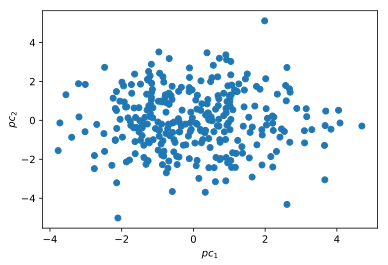

In [26]:
fig, ax = plt.subplots()

ax.scatter(*Z_pca.T)

ax.set_xlabel('$pc_1$')
ax.set_ylabel('$pc_2$')

plt.show()

We'd like to visualize the original sketches at their corresponding points on this plot. Each point corresponds to the latent code of a sketch, reduced to 2 dimensions. However, the plot is slightly too dense to fit sufficiently large sketches without overlapping them. Therefore, we restrict our attention to a smaller region that encompasses 80% of the data points, discarding those outside of the 5th and 95th percentiles in both axes. The blue shaded rectangle highlights our region of interest.

In [106]:
((pc1_min, pc2_min), 
 (pc1_max, pc2_max)) = np.percentile(Z_pca, q=[5, 95], axis=0)

In [107]:
roi_rect = patches.Rectangle(xy=(pc1_min, pc2_min),
                             width=pc1_max-pc1_min,
                             height=pc2_max-pc2_min, alpha=.4)

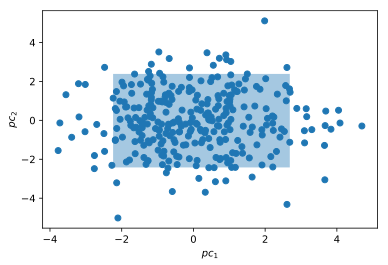

In [108]:
fig, ax = plt.subplots()

ax.scatter(*Z_pca.T)
ax.add_patch(roi_rect)

ax.set_xlabel('$pc_1$')
ax.set_ylabel('$pc_2$')

plt.show()

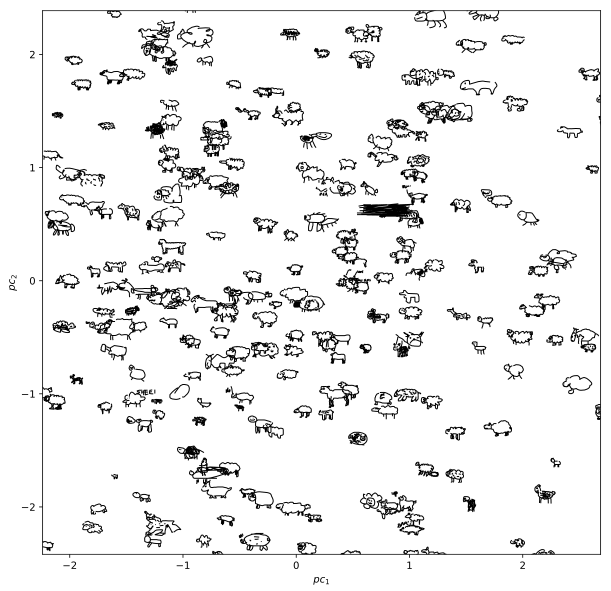

In [109]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim(pc1_min, pc1_max)
ax.set_ylim(pc2_min, pc2_max)

for i, sketch in enumerate(test_set.strokes):
    sketch_path = SketchPath(sketch, factor=7e+1)
    sketch_path.vertices[::,1] *= -1
    sketch_path.vertices += Z_pca[i]
    patch = patches.PathPatch(sketch_path, facecolor='none')
    ax.add_patch(patch)

ax.set_xlabel('$pc_1$')
ax.set_ylabel('$pc_2$')
    
plt.savefig("../../files/sketchrnn/aaron_sheep_pca.svg", 
            format="svg", dpi=1200)

You can find the SVG image [here](../../../sketchrnn/aaron_sheep_pca.svg).

*Remark:* There is a far more clever way to produce this plot that involves the use of [matplotlib Transformations](https://matplotlib.org/users/transforms_tutorial.html) and the [Collections API](https://matplotlib.org/api/collections_api.html#matplotlib.collections.PathCollection), by instantiating `PathCollection` with the keyword arguments `offets` defined as the array of projected locations (in this instance `Z_pca`). However, I was unable to get this to work (maybe I was working in the wrong coordinate system?). In either case, if you find a slicker way to produce this plot, please let me know. I'd love to learn about your approach!

#### Linear Interpolation in PCA Projection

We generate of grid of 100 uniformly spaced points in the subspace spanned by the first 2 principal axes, in the rectangular region of interest defined previously (starting at the 5th percentile and ending at the 95th percentile). The grid of points are shown in orange below, overlayed on top of the test data points.

In [35]:
pc1 = lerp(pc1_min, pc1_max, np.linspace(0, 1, 10))

In [36]:
pc2 = lerp(pc2_min, pc2_max, np.linspace(0, 1, 10))

In [37]:
pc1_mesh, pc2_mesh = np.meshgrid(pc1, pc2)

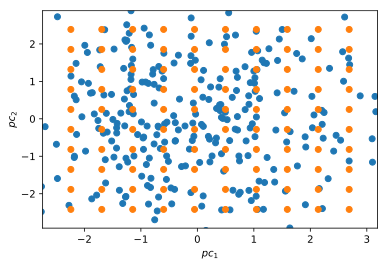

In [38]:
fig, ax = plt.subplots()

ax.set_xlim(pc1_min-.5, pc1_max+.5)
ax.set_ylim(pc2_min-.5, pc2_max+.5)

ax.scatter(*Z_pca.T)
ax.scatter(pc1_mesh, pc2_mesh)

ax.set_xlabel('$pc_1$')
ax.set_ylabel('$pc_2$')

plt.show()

Next, we're interested in applying the inverse transform of the PCA to project the 100 points on the grid to the original 128-dimensional latent space.

In [39]:
np.dstack((pc1_mesh, pc2_mesh)).shape

(10, 10, 2)

In [40]:
z_grid = np.apply_along_axis(pca.inverse_transform,  
                             arr=np.dstack((pc1_mesh, pc2_mesh)),
                             axis=2)
z_grid.shape

(10, 10, 128)

Then, we use these latent codes to reconstruct the corresponding sketch with our decoder, and observe how the sketch transitions between extents of the rectangular region of interest. Of particular interest is how the sketch transitions from left to right, and then top to bottom, as these are the directions that account for the most variance in the latent representations. First, we run our decoder with a relatively low temperature setting $\tau=0.1$ to minimize randomness in our samples. 

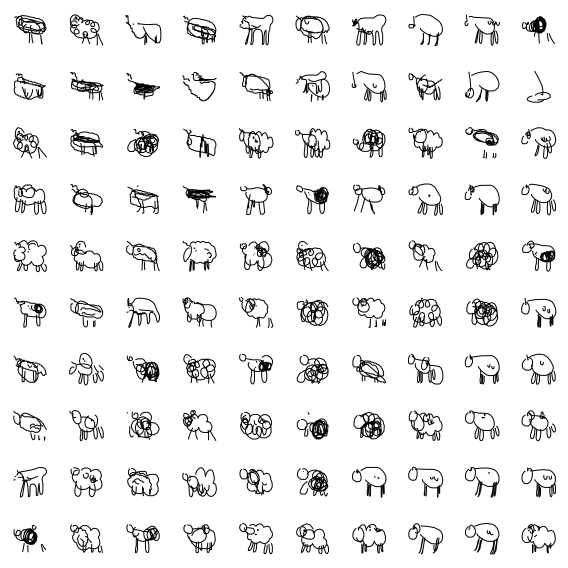

In [94]:
fig, ax_arr = plt.subplots(nrows=10, 
                           ncols=10, 
                           figsize=(8, 8),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
fig.tight_layout()

for i, ax_row in enumerate(ax_arr):    
    for j, ax in enumerate(ax_row):
        draw(decode(z_grid[-i-1,j], temperature=.1), ax=ax)
        ax.axis('off')
    
plt.show()

You can definitely observe some interesting transitions and patterns here. In the bottom-right corner, you can see a cluster of similar-looking sheep, appearing sheared and unostentatious. As you move up and to the left, you begin to see some sheep with crudely-drawn circular scribbles for fur. Along the middle rows is where you see the most realistic-looking sheep. In the top-left corner, the sketches begin to get a little uh... shall we say, abstract. Like it was drawn by someone who really longed to see a sheep. 

Running it with temperature $\tau=0.6$ doesn't yield much further insight.

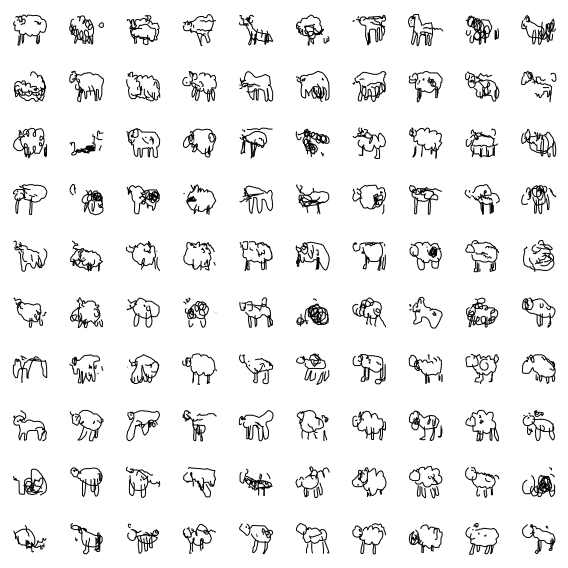

In [95]:
fig, ax_arr = plt.subplots(nrows=10, 
                           ncols=10, 
                           figsize=(8, 8),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
fig.tight_layout()

for i, ax_row in enumerate(ax_arr):    
    for j, ax in enumerate(ax_row):
        draw(decode(z_grid[-i-1,j], temperature=.6), ax=ax)
        ax.axis('off')
    
plt.show()

#### Eigensheep Decomposition

The principal components of the learned latent representation of sheep sketches are often referred to as the *eigensheep*... by me. And now by you. 

Using the decoder, we can visualize the sketch representation of the first 2 eigensheep. These eigensheep are the orthogonal weight vectors that transform the latent representations into the 2-dimensional subspace we've been working in. They are just 128-dimensional vectors which, by themselves, are largely inscrutable. By treating them as latent codes, and reconstructing them as sketches with the decoder, we might be able to distill some meaningful interpretation.

In [48]:
z_pc1, z_pc2 = pca.components_

In [49]:
pca.explained_variance_ratio_

array([ 0.02140247,  0.02067117])

In [50]:
pca.explained_variance_

array([ 2.51394317,  2.42804484])

We draw the reconstructed sketches of the eigensheep at increasing temperatures from $\tau=0.1 \dotsc 1.0$, taking 5 samples for each temperature setting.

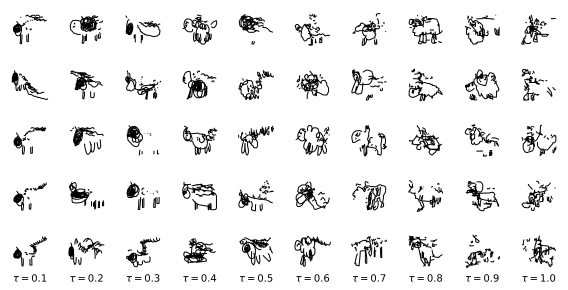

In [58]:
fig, ax_arr = plt.subplots(nrows=5, 
                           ncols=10, 
                           figsize=(8, 4),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
fig.tight_layout()

for row_num, ax_row in enumerate(ax_arr):    
    for col_num, ax in enumerate(ax_row):
        t = (col_num + 1) / 10.
        draw(decode(z_pc1, temperature=t), ax=ax)

        if row_num + 1 == len(ax_arr):
            ax.set_xlabel(r'$\tau={}$'.format(t))
        
plt.show()

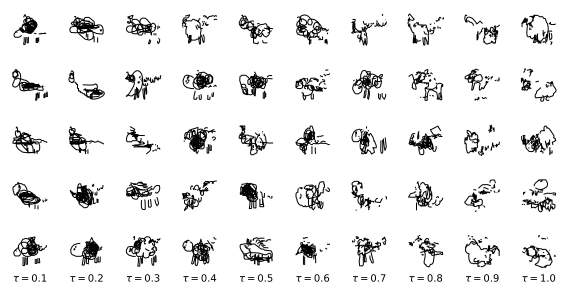

In [63]:
fig, ax_arr = plt.subplots(nrows=5, 
                           ncols=10, 
                           figsize=(8, 4),
                           subplot_kw=dict(xticks=[],
                                           yticks=[],
                                           frame_on=False))
fig.tight_layout()

for row_num, ax_row in enumerate(ax_arr):    
    for col_num, ax in enumerate(ax_row):
        t = (col_num + 1) / 10.
        draw(decode(z_pc2, temperature=t), ax=ax)

        if row_num + 1 == len(ax_arr):
            ax.set_xlabel(r'$\tau={}$'.format(t))
        
plt.show()

This reminds me a bit of [eigenfaces](https://en.wikipedia.org/wiki/Eigenface) in facial recognition datasets, where you get dark blurs that highlight the most prominent features of a human face -- the eyes, nose, and mouth. The results are usually terrifying images of unsettling faces with [deep, dark, sunken eyes](http://crockpotveggies.com/uploads/tinderbox_eigenfaces_models.jpg) and [creepy smiles](http://1.bp.blogspot.com/-b6C0IpjVsRM/UXrHbCh-lxI/AAAAAAAAWro/_jiN1yy2vlM/s1600/eigface.png).

The reconstructions of the eigensheep above at lower temperature setting reveal more interesting patterns. For the first eigensheep, at $\tau=0.1$, you mostly see a pattern of round, black heads with two long, round legs, and some kind of tail (or possibly [cape](http://worms.wikia.com/wiki/Super_Sheep)?) This axis seems to be along the direction that consists of variations in the structure of the head and legs of the sheep, and it would make sense that this accounts for most of the variance in the sketches. A look at the variation in the grid of reconstructed sketches above, going from left to right, seems to be consistent with this conjecture.

Looking at the second eigensheep, again concentrating on the samples generated with the lower temperatures, we see some roughly scribbled circles representing the body, with 3-4 loosely attached legs and a tiny round head. Unlike the first principal axis, this one seems to be along the direction that consists of variations primarily in the structure of the body of thye sheep. Again, studying the transitions from top to bottom in the grid above seems consistent with this.

## t-SNE Visualization

The t-distributed Stochastic Neighbor Embedding (t-SNE) is a popular non-linear dimensionality reduction technique that is commonly used to visualize high-dimensional data. It is one of several embedding methods that seeks to embed data points in a lower dimensional space in such a way as to preserve the pairwise distances of the points in the original, higher dimensional space. t-SNE does so in a non-linear fashion and adapts to the underlying data, performing different transformations on different regions[^distill].

In particular, t-SNE is commonly used in deep learning to inspect and visualize what a deep neural network has learned. For example, in an image classification problem, we can view a convolutional neural net as a series of transformations that gradually turns an image into a representation such that the classes can be more easily separated by a linear classifier[^cs231n]. Therefore, we can use the output of the final layer preceding the classifier as the 'code'. The code representations of the images can then be embedded and visualized in 2-dimensions using t-SNE.

Here, we embed the 128-dimensional latent code of each vector drawing in 2-dimensions and visualize them in this subspace.

[^distill]: Wattenberg, et al., "How to Use t-SNE Effectively", Distill, 2016. http://doi.org/10.23915/distill.00002

[^cs231n]: Paraphrased from the Stanford [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/) course notes on [Understanding and Visualizing Convolutional Neural Networks](http://cs231n.github.io/understanding-cnn/).

In [97]:
tsne = TSNE(n_components=2, n_iter=5000)

In [98]:
Z_tsne = tsne.fit_transform(Z)

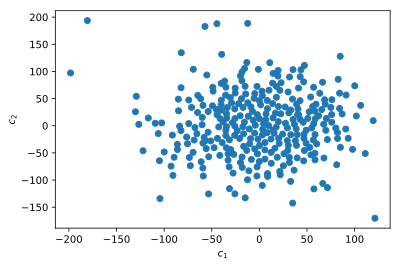

In [99]:
fig, ax = plt.subplots()

ax.scatter(*Z_tsne.T)

ax.set_xlabel('$c_1$')
ax.set_ylabel('$c_2$')

plt.show()

In [100]:
tsne.kl_divergence_

2.2818214893341064

As before, we define a rectangular region of interest

In [ ]:
((c1_min, c2_min), 
 (c1_max, c2_max)) = np.percentile(Z_tsne, q=[5, 95], axis=0)

In [102]:
roi_rect = patches.Rectangle(xy=(c1_min, c2_min),
                             width=c1_max-c1_min,
                             height=c2_max-c2_min, alpha=.4)

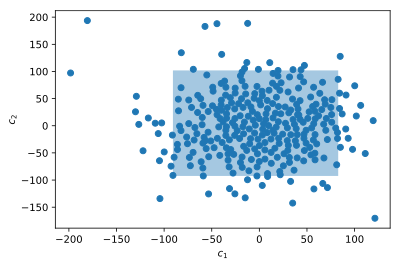

In [103]:
fig, ax = plt.subplots()

ax.scatter(*Z_tsne.T)
ax.add_patch(roi_rect)

ax.set_xlabel('$c_1$')
ax.set_ylabel('$c_2$')

plt.show()

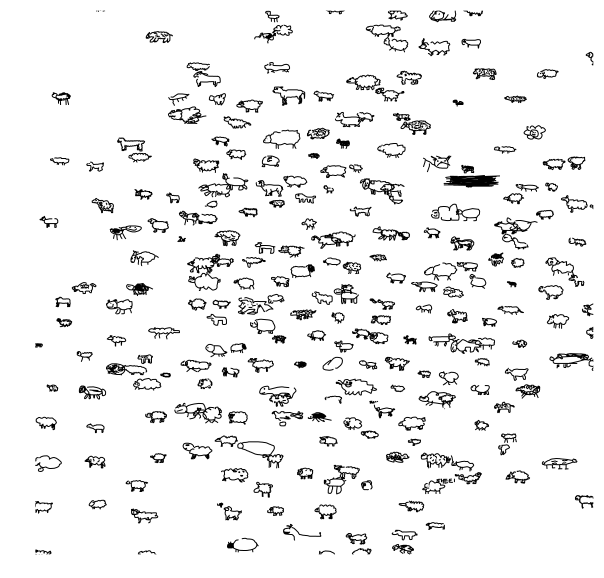

In [104]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim(c1_min, c1_max)
ax.set_ylim(c2_min, c2_max)

for i, sketch in enumerate(test_set.strokes):
    sketch_path = SketchPath(sketch, factor=2.)
    sketch_path.vertices[::,1] *= -1
    sketch_path.vertices += Z_tsne[i]
    patch = patches.PathPatch(sketch_path, facecolor='none')
    ax.add_patch(patch)

ax.axis('off')

plt.savefig("../../files/sketchrnn/aaron_sheep_tsne.svg", 
            format="svg")

The full SVG image is available [here](../../../sketchrnn/aaron_sheep_tsne.svg). While this yields good results, I think this visualization would be far more compelling on a larger dataset with multiple classes. That way, you can actually see if t-SNE effectively forms clusters of drawings beloging to the different classes, and highlight the variation within each cluster. In the next post in the series, I will train the SketchRNN model from scratch on a subset of the QuickDraw dataset. The dataset will consist of multiple classes and be an order of magnitude larger than the `aaron-sheep` dataset.

---

With an RGB raster image, you can usually obtain meaningful, visually-pleasing results by directly embedding the raw pixel values in 2-dimensions using a technique like t-SNE. However, the similarities will tend to be superficial, based mostly on color, lighting, etc. When we embed their code representations, the similarities become more abstract and high-level, and tend to be class-based and semantic[^karpathy]. Furthermore, it allows us to inspect what high-level concepts the neural network has formed about what constitutes the notion of similarity.

On the other hand, a vector drawing is constituted of a sequence of pen strokes, which are represented as a sequences of offsets on a Cartesian plane. In general, measures of similarity between arbitrary-length sequences are not so well-defined. Therefore, you can't directly apply dimensionality reduction techniques on vector drawings as you would raster images, where you can simply apply some distance metric in the RGB pixel space. 

Using variational recurrent neural networks such as SketchRNN, we can transform raw vector drawings into richer representations in a latent space where distance metrics are well-defined. Doing so allows us to apply powerful techniques such as t-SNE to organize and visualize them, and other kinds of sequential data, using concepts of similarity that are more semantic and abstract.

This work was inspired in part by the excellent articles written by Chris Olah on [Visualizing MNIST](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) and [Visualizing Representations](http://colah.github.io/posts/2015-01-Visualizing-Representations/), and [other works](https://medium.com/@juliendespois/latent-space-visualization-deep-learning-bits-2-bd09a46920df) that visualize latent spaces using t-SNE, such as the works on [Analyzing 50k fonts using deep neural networks](https://erikbern.com/2016/01/21/analyzing-50k-fonts-using-deep-neural-networks.html), and [Organizing the World of Fonts with AI](https://medium.com/ideo-stories/organizing-the-world-of-fonts-with-ai-7d9e49ff2b25).

[^karpathy]: A great example is Andrej Karpathy's visualization of ILSVRC 2012 images using t-SNE on 4096-dimensional codes from the final layer of a Convolutional Neural Network: http://cs.stanford.edu/people/karpathy/cnnembed/